In [ ]:
# All required libraries imported and warnings suppresed

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

# Configuring some pandas options

pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

# Getting data

In [ ]:
# Checking the fraud to non-fraud ratio

df = pd.read_csv("/content/drive/MyDrive/Chapters/creditcard_sampledata.csv")

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8000 non-null   int64  
 1   Time        8000 non-null   int64  
 2   V1          8000 non-null   float64
 3   V2          8000 non-null   float64
 4   V3          8000 non-null   float64
 5   V4          8000 non-null   float64
 6   V5          8000 non-null   float64
 7   V6          8000 non-null   float64
 8   V7          8000 non-null   float64
 9   V8          8000 non-null   float64
 10  V9          8000 non-null   float64
 11  V10         8000 non-null   float64
 12  V11         8000 non-null   float64
 13  V12         8000 non-null   float64
 14  V13         8000 non-null   float64
 15  V14         8000 non-null   float64
 16  V15         8000 non-null   float64
 17  V16         8000 non-null   float64
 18  V17         8000 non-null   float64
 19  V18         8000 non-null  

In [ ]:
occ = df["Class"].value_counts()
print(occ)

ratio_cases = occ / len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

# The ratio of fraudulent transactions is very low. This is a case of class imbalance problem.

0    7983
1      17
Name: Class, dtype: int64
Ratio of fraudulent cases: 0.002125
Ratio of non-fraudulent cases: 0.997875


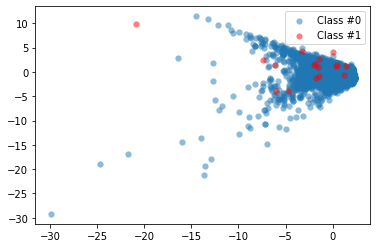

In [ ]:
# Data Visualization 

def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()


X, y = prep_data(df)
plot_data(X, y)

# By visualizing the data, you can immediately see how our fraud cases are scattered over our data,
# and how few cases we have. A picture often makes the imbalance problem clear. In the next exercises we'll visually
# explore how to improve our fraud to non-fraud balance.

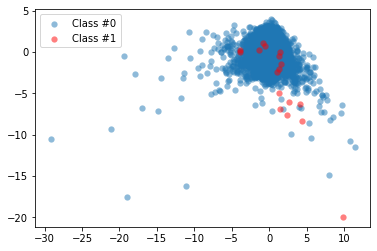

In [ ]:
plt.scatter(df.V2[df.Class == 0], df.V3[df.Class == 0], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.V2[df.Class == 1], df.V3[df.Class == 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.legend()
plt.show()

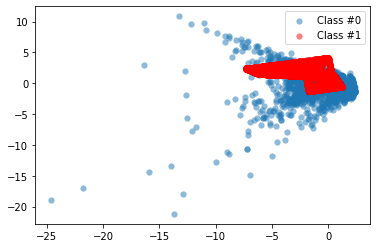

In [ ]:
# Define resampling method and split into train and test
method = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

# print(f'X shape: {X.shape}\ny shape: {y.shape}')

# Continue fitting the model and obtain predictions
#model = LogisticRegression()
#model.fit(X_resampled, y_resampled)

# Get model performance metrics
#predicted = model.predict(X_test)
#print(classification_report(y_test, predicted))

plot_data(X_resampled, y_resampled)

# if fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases,
# introduces noise into the data, as the nearest neighbors might not be fraud cases

0    7983
1      17
dtype: int64
0    6389
1    6389
dtype: int64


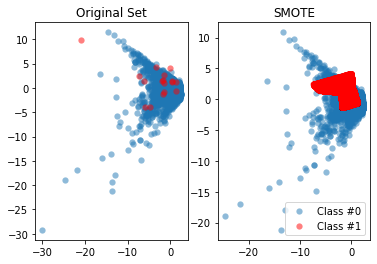

In [ ]:
print(pd.value_counts(pd.Series(y)))
print(pd.value_counts(pd.Series(y_resampled)))

def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

In [ ]:
# Using thresholds to catch frauds (without SMOTE)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.groupby('Class').mean()
df['flag_as_fraud'] = np.where(np.logical_and(df.V1 < -3, df.V3 < -5), 1, 0)

In [ ]:
print(pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              7949  34
1                13   4


In [ ]:
#Using ML to catch frauds (without SMOTE)

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit a logistic regression model to our data
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2390
           1       1.00      0.30      0.46        10

    accuracy                           1.00      2400
   macro avg       1.00      0.65      0.73      2400
weighted avg       1.00      1.00      1.00      2400

Confusion matrix:
 [[2390    0]
 [   7    3]]


In [ ]:
# Logistic regression with SMOTE

# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

pipeline = Pipeline([("SMOTE", resampling),("Logistic Regression", model)])

# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      2390
           1       0.33      0.60      0.43        10

    accuracy                           0.99      2400
   macro avg       0.67      0.80      0.71      2400
weighted avg       1.00      0.99      0.99      2400

Confusion matrix:
 [[2378   12]
 [   4    6]]


In [ ]:
# Fraud detection using labeled data

df2 = pd.read_csv("/content/drive/MyDrive/Chapters/creditcard_sampledata_2.csv")
df2.head()

X, y = prep_data(df2)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

total_obs = len(y)

non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
print(count_non_fraud)

percentage = (count_non_fraud/total_obs) * 100
print(f'{percentage:0.2f}%')

# This tells us that by doing nothing, we would be correct in 95.9% of the cases.
# So now you understand, that if we get an accuracy of less than this number,
# our model does not actually add any value in predicting how many cases are correct.
# Let's see how a random forest does in predicting fraud in our data.

X shape: (7300, 28)
y shape: (7300,)
7000
95.89%


In [ ]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Define the model as the random forest
model = RandomForestClassifier(random_state=5, n_estimators=20)

model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

#Random Forest prevents overfitting most of the time, by creating random subsets of the features and building 
# smaller trees using these subsets. Afterwards, it combines the subtrees of subsamples of features,
# so it does not tend to overfit to your entire feature set the way "deep" Decisions Trees do.

Accuracy Score:
0.991


In [ ]:
# Performance metrics for the RF model

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

#You have now obtained more meaningful performance metrics that tell us how well the model performs, 
# given the highly imbalanced data that you're working with. The model predicts 76 cases of fraud, out of which 73 are actual fraud.
# You have only 3 false positives. This is really good, and as a result you have a very high precision score.
# You do however, miss 18 cases of actual fraud. Recall is therefore not as good as precision.

ROC Score:
0.9419896444670147

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  18   73]]


Precision: [0.04155251 0.97333333 1.        ]
Recall: [1.        0.8021978 0.       ]


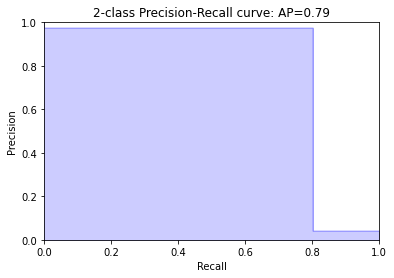

In [ ]:
# Plotting the Precision vs. Recall Curve

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)
print(f'Precision: {precision}\nRecall: {recall}')

def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
    return plt.show()

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

# The AUROC answers the question: "How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?"
# but precision and recall don't.

In [ ]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5, n_estimators=100)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9750299724096771

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2098    1]
 [  18   73]]


In [ ]:
# Adjusting RF for fraud detection

def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

# Change the model options
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               # Change depth of model
                               max_depth=10,
                               # Change the number of samples in leaf nodes
                               min_samples_leaf=10, 
                               # Change the number of trees to use
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9609651901219315

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.85      0.91        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  14   77]]


# Parameter optimization with GridSearchCV

In [ ]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

In [ ]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='log2', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9749697658225529

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2095    4]
 [  15   76]]


In [ ]:
# Ensemble methods

# logistic regression alone

# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, solver='liblinear')

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

# As you can see the Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better Recall.
# It will therefore will a useful addition to the Random Forest in an ensemble model.

ROC Score:
0.9722054981702433

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.63      0.88      0.73        91

    accuracy                           0.97      2190
   macro avg       0.81      0.93      0.86      2190
weighted avg       0.98      0.97      0.98      2190


Confusion Matrix:
[[2052   47]
 [  11   80]]


In [ ]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, 
                              criterion='gini', 
                              max_depth=8, 
                              max_features='log2',
                              min_samples_leaf=10, 
                              n_estimators=30, 
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

# By combining the classifiers, you can take the best of multiple models. You've increased the cases of fraud you are catching from 76 to 78,
# and you only have 5 extra false positives in return. If you do care about catching as many fraud cases as you can,whilst keeping the false positives 
# low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the 
# Random Forest was worse in terms of false negatives. By combining these together you indeed managed to improve performance.


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.90      0.86      0.88        91

    accuracy                           0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2090    9]
 [  13   78]]


In [ ]:
# Adjusting weights within the Voting Classifier

# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

# The weight option allows you to play with the individual models to get the best final mix for your fraud detection model.
# Now that you have finalized fraud detection with supervised learning, let's have a look at how fraud detetion can be done when 
# you don't have any labels to train on.

ROC Score:
0.9739226947421326

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.85      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2094    5]
 [  14   77]]


# Fraud detection using unlabeled data

In [ ]:
banksim_df = pd.read_csv("/content/drive/MyDrive/Chapters/banksim.csv")
banksim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
banksim_adj_df = pd.read_csv("/content/drive/MyDrive/Chapters/banksim_adj.csv")
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(banksim_df.shape)
print(banksim_df.head())
print(banksim_adj_df.shape)
print(banksim_adj_df.head())

print(banksim_df.groupby(['category']).mean())

(7200, 5)
  age gender           category  amount  fraud
0   3      F  es_transportation   49.71      0
1   4      F          es_health   39.29      0
2   3      F  es_transportation   18.76      0
3   4      M  es_transportation   13.95      0
4   2      M  es_transportation   49.87      0
(7189, 18)
   age  amount  fraud  M  es_barsandrestaurants  es_contents  es_fashion  \
0    3   49.71      0  0                      0            0           0   
1    4   39.29      0  0                      0            0           0   
2    3   18.76      0  0                      0            0           0   
3    4   13.95      0  1                      0            0           0   
4    2   49.87      0  1                      0            0           0   

   es_food  es_health  es_home  es_hotelservices  es_hyper  es_leisure  \
0        0          0        0                 0         0           0   
1        0          1        0                 0         0           0   
2        0        

In [ ]:
print(banksim_df.groupby(['age']).mean())
print(banksim_df.age.value_counts())

        amount     fraud
age                     
0    49.468935  0.050000
1    35.622829  0.026648
2    37.228665  0.028718
3    37.279338  0.023283
4    36.197985  0.035966
5    37.547521  0.023990
6    36.700852  0.022293
U    39.117000  0.000000
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64


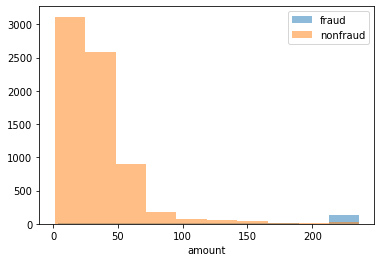

In [ ]:
# Using statistics to define normal behavior

# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

# Clustering methods to detect fraud

In [ ]:
labels = banksim_adj_df.fraud

cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

# Take the float values of df for X
X = banksim_adj_df[cols].values.astype(np.float)
print(X.shape)
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(X, "\n")
print(X_scaled)

(7189, 17)
[[  3.      49.71     0.     ...   0.       1.       0.    ]
 [  4.      39.29     0.     ...   0.       0.       0.    ]
 [  3.      18.76     0.     ...   0.       1.       0.    ]
 ...
 [  1.     236.1474   0.     ...   0.       0.       1.    ]
 [  1.     236.1474   1.     ...   0.       0.       0.    ]
 [  4.     236.1474   0.     ...   0.       0.       0.    ]] 

[[0.5        0.20681002 0.         ... 0.         1.         0.        ]
 [0.66666667 0.16247858 0.         ... 0.         0.         0.        ]
 [0.5        0.07513457 0.         ... 0.         1.         0.        ]
 ...
 [0.16666667 1.         0.         ... 0.         0.         1.        ]
 [0.16666667 1.         1.         ... 0.         0.         0.        ]
 [0.66666667 1.         0.         ... 0.         0.         0.        ]]


In [ ]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

# Elbow method - to figure out the right number of clusters to use

MiniBatchKMeans(random_state=0)

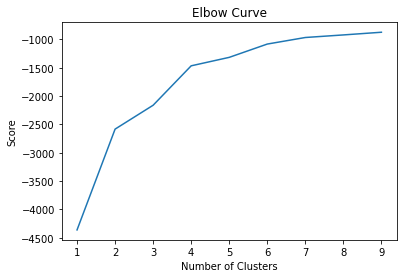

In [ ]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Confusion matrix, without normalization


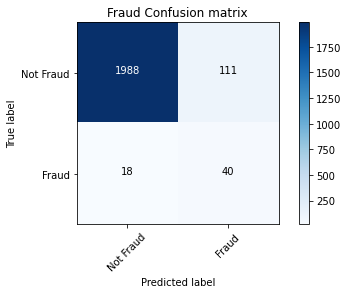

0.8183864237485832


In [ ]:
# Detecting Outliers

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 93)] = 1
km_y_pred[dist < np.percentile(dist, 93)] = 0

def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Obtain the ROC score
score = roc_auc_score(y_test, km_y_pred)

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

print(score)

In [ ]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


In [ ]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]
The smallest clusters are clusters: [21 17  9]
